In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

data = pd.read_csv("input/type_Ia_lt_001.csv")

print(data.head(10))

        Name  Disc. Date     Host Name                         z  dL (Mpc)  \
0    SN1972E  1972/05/06      NGC 5253                  0.001358    2.7000   
1    SN1895B  1895/07/07      NGC 5253                    0.0014    2.7000   
2    SN1986G  1986/05/03      NGC 5128  0.00183,0.000848,0.00103    2.8000   
3    SN1937C  1937/08/16       IC 4182         0.001071,0.001071    3.0000   
4    SN1983N  1983/07/03      NGC 5236   0.00308,0.00321,0.00171    4.3000   
5  SN2021abt  2021/01/10  LEDA 1022096                  0.001429    6.3312   
6   SN2012cg  2012/05/17      NGC 4424                  0.001458    6.4598   
7    SN1937D  1937/09/09      NGC 1003                   0.00518    8.0000   
8    SN1971I  1971/05/24      NGC 5055           0.00131,0.00344    8.0000   
9   SN2010el  2010/06/19      NGC 1566               0.005,0.005    8.0000   

      Type  
0       Ia  
1       Ia  
2  Ia-91bg  
3       Ia  
4       Ib  
5       Ia  
6       Ia  
7       Ia  
8       Ia  
9  Ia-02cx 

In [2]:
data.dropna(subset=['z','dL (Mpc)'], inplace=True)
data_a = data["z"].str.split(",", expand=True)
data["z"] = data_a[0].astype(float)
print(data.head(10))

        Name  Disc. Date     Host Name         z  dL (Mpc)     Type
0    SN1972E  1972/05/06      NGC 5253  0.001358    2.7000       Ia
1    SN1895B  1895/07/07      NGC 5253  0.001400    2.7000       Ia
2    SN1986G  1986/05/03      NGC 5128  0.001830    2.8000  Ia-91bg
3    SN1937C  1937/08/16       IC 4182  0.001071    3.0000       Ia
4    SN1983N  1983/07/03      NGC 5236  0.003080    4.3000       Ib
5  SN2021abt  2021/01/10  LEDA 1022096  0.001429    6.3312       Ia
6   SN2012cg  2012/05/17      NGC 4424  0.001458    6.4598       Ia
7    SN1937D  1937/09/09      NGC 1003  0.005180    8.0000       Ia
8    SN1971I  1971/05/24      NGC 5055  0.001310    8.0000       Ia
9   SN2010el  2010/06/19      NGC 1566  0.005000    8.0000  Ia-02cx


In [12]:
# z<0.1かつType-Iaのものを抽出(extracting)．
data_ext = data[(data["z"]<0.1) & (data["Type"]=="Ia")]
print(data_ext.head(10))


         Name  Disc. Date     Host Name         z  dL (Mpc) Type
0     SN1972E  1972/05/06      NGC 5253  0.001358    2.7000   Ia
1     SN1895B  1895/07/07      NGC 5253  0.001400    2.7000   Ia
3     SN1937C  1937/08/16       IC 4182  0.001071    3.0000   Ia
5   SN2021abt  2021/01/10  LEDA 1022096  0.001429    6.3312   Ia
6    SN2012cg  2012/05/17      NGC 4424  0.001458    6.4598   Ia
7     SN1937D  1937/09/09      NGC 1003  0.005180    8.0000   Ia
8     SN1971I  1971/05/24      NGC 5055  0.001310    8.0000   Ia
10  SN2021qvv  2021/06/23      NGC 4442  0.001825    8.0881   Ia
11  SN2021hcz  2021/03/24      NGC 1400  0.001861    8.2479   Ia
12    SN1989B  1989/01/30      NGC 3627  0.002425    9.0000   Ia


*input*************
         Name  Disc. Date     Host Name         z  dL (Mpc) Type
0     SN1972E  1972/05/06      NGC 5253  0.001358    2.7000   Ia
1     SN1895B  1895/07/07      NGC 5253  0.001400    2.7000   Ia
3     SN1937C  1937/08/16       IC 4182  0.001071    3.0000   Ia
5   SN2021abt  2021/01/10  LEDA 1022096  0.001429    6.3312   Ia
6    SN2012cg  2012/05/17      NGC 4424  0.001458    6.4598   Ia
7     SN1937D  1937/09/09      NGC 1003  0.005180    8.0000   Ia
8     SN1971I  1971/05/24      NGC 5055  0.001310    8.0000   Ia
10  SN2021qvv  2021/06/23      NGC 4442  0.001825    8.0881   Ia
11  SN2021hcz  2021/03/24      NGC 1400  0.001861    8.2479   Ia
12    SN1989B  1989/01/30      NGC 3627  0.002425    9.0000   Ia
*******************
*Result************
y = ax + b
a =  4782.177150090044 +- 2.186832224300236
b =  -7.687425469405795 +- 0.1233155732844946
*******************


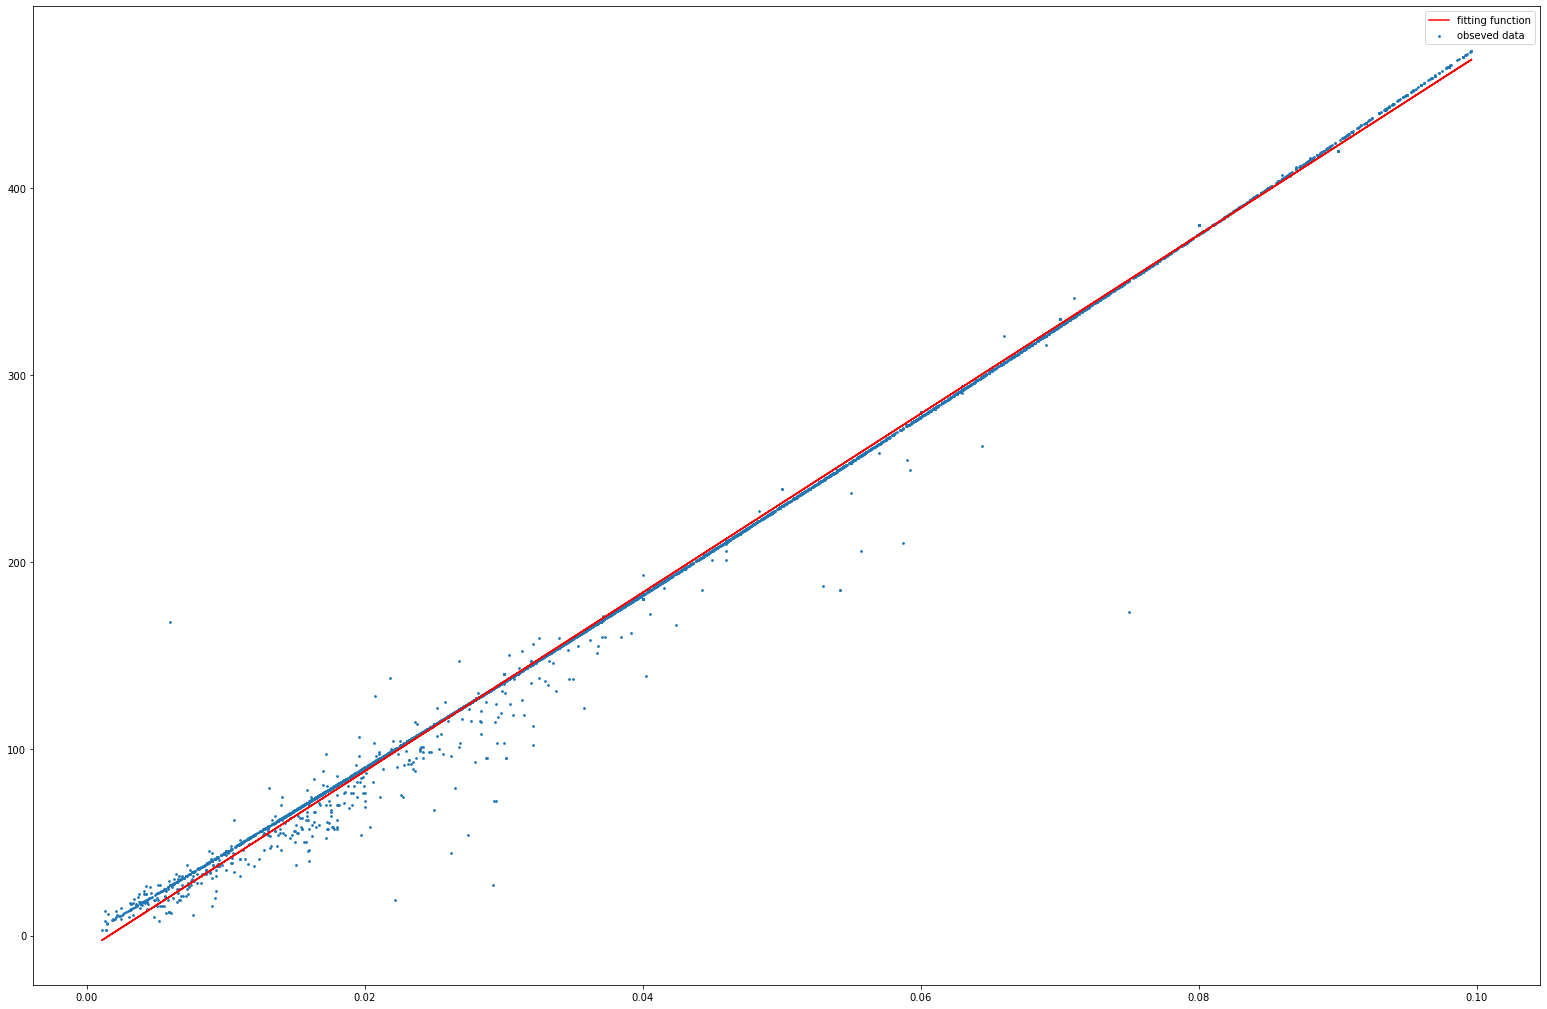

In [26]:
#fittingを行うメインの関数
def fitting_linear(data):
    z_observed = data["z"]
    dl_observed = data["dL (Mpc)"]
    #モデル式を表す関数
    def linear_func(X, a, b): # １次式 Y=ax+b
        Y = a * X + b
        return Y
    
    # plot部分
    def linear_plot():
        x = z_observed
        y = x*popt[0]+popt[1]
        plt.plot(x, y, color = "red", label="fitting function")
        plt.scatter(z_observed, dl_observed, s=3, label="obseved data")
        plt.rcParams["figure.figsize"] = [27,18]
        plt.legend()
        plt.show()
        
 
    #fittingのメイン計算部分
    popt, pcov = curve_fit(linear_func,z_observed,dl_observed) #poptは最適推定値、pcovは共分散が出力される
    perr = np.sqrt(np.diag(pcov)) #推定されたパラメータの各々の誤差
 
    #fittingの結果をターミナルに表示
    print("*input*************")
    print(data.head(10))
    print("*******************")
    print("*Result************")
    print("y = ax + b")
    print("a = ", popt[0], "+-", perr[0])
    print("b = ", popt[1], "+-", perr[1])
    print("*******************")
    linear_plot()
    return

fitting_linear(data_ext)
